# Processing of the Quis-Campi / ICB-RW dataset

In [11]:
import os.path as osp
from insightface.app import FaceAnalysis
import csv
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from numba import jit

In [ ]:
app = FaceAnalysis(name='arcface_sepaelv1', allowed_modules=['detection','recognition'],providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0, det_size=[160,160])

In [4]:
galleryFolder = "/media/data/recfac/bases/icbrw/icbrw_GalleryImages"
galleryAnnotations = "/media/data/recfac/bases/icbrw/annotations_GalleryImages.txt"


probeFolder = "/media/data/recfac/bases/icbrw/icbrw_ProbeImages"
probeAnnotations = "/media/data/recfac/bases/icbrw/annotations_ProbeImages.txt"

In [5]:
def get_features(rgbImg):
    center_of_image = np.array([int(rgbImg.shape[0]/2),int(rgbImg.shape[1]/2)])
    faces = app.get(rgbImg)
    dist=[]
    
    # Indicate if no face is detected
    if len(faces) == 0:
        #print("No face found on {}".format(imgPath))
        return "no face", np.empty(512)
    
    # Compute center of faces and distances from certer of image
    for face in faces:
        box=face.bbox.astype('int').flatten()
        center_of_face = np.array([int((box[0]+box[2])/2),int((box[1]+box[3])/2)])
        dist.append(np.linalg.norm(center_of_image-center_of_face))
    
    # Get embeddings of the face with center closest to the center of the image
    idx_face = dist.index(min(dist))
    rep = faces[idx_face].embedding
    
    
    return "ok", rep

In [114]:
with open(galleryAnnotations,'r') as csvFile:
        csvreader = csv.reader(csvFile, delimiter=" ")
        d = []
        for imgName, x, y, w, h  in tqdm(csvreader):
            identity = imgName.split("_")[0]
            img = cv2.imread(osp.join(galleryFolder,imgName))
            
            x, y = int(x), int(y)
            w, h = int(w), int(h)
            xc = x + w//2
            yc = y + h//2
            x0 = int(xc - w/1.0) if (xc - w/1.0 >= 0) else 0
            x1 = int(xc + w/1.0) if (xc + w/1.0 < img.shape[1]) else img.shape[1]-1
            y0 = int(yc - h/1.0) if (yc - h/1.0 >= 0) else 0
            y1 = int(yc + h/1.0) if (yc + h/1.0 < img.shape[0]) else img.shape[0]-1
            
            imgCrop = img[y0:y1, x0:x1]
            cv2.imwrite("/media/data/recfac/bases/icbrw/galleryFaces160/"+imgName,imgCrop)
            status, features = get_features(imgCrop)
            if status == "no face":
                print("No face:", imgName)
            d.append({'identity':identity,'image':imgName, 'status':status, 'features':features})

270it [00:28,  9.43it/s]


In [115]:
gallery = pd.DataFrame(d)
gallery

,identity,image,status,features
0,001,001_f.jpg,ok,"[0.33129525, 1.3214277, 0.64877397, 1.5087295,..."
1,001,001_l.jpg,ok,"[1.7166444, 0.02798095, 0.05152478, 0.3633684,..."
2,001,001_r.jpg,ok,"[0.8395859, 0.25351444, 0.6822058, 1.2758213, ..."
3,002,002_f.jpg,ok,"[-1.1031075, -0.34398636, -0.10092511, 0.65840..."
4,002,002_l.jpg,ok,"[-1.8486379, -1.6998981, -1.6032494, -1.601236..."
...,...,...,...,...
265,089,089_l.jpg,ok,"[-0.6037785, -1.6414697, 0.6061103, -0.1601041..."
266,089,089_r.jpg,ok,"[-1.403269, -1.3006608, -1.0525557, -1.6308051..."
267,090,090_f.jpg,ok,"[0.3700745, -0.53741986, -0.6371303, -0.271145..."
268,090,090_l.jpg,ok,"[0.03188739, -0.7606555, -1.1137182, 0.4108289..."


In [116]:
with open("/media/data/recfac/bases/icbrw/galleryEmbeddings.pkl","wb") as f:
    pickle.dump(d,f)

In [119]:
with open(probeAnnotations,'r') as csvFile:
        csvreader = csv.reader(csvFile, delimiter=" ")
        d = []
        for imgName, x, y, w, h  in tqdm(csvreader):
            identity = imgName.split("_")[0]
            img = cv2.imread(osp.join(probeFolder,imgName))
            x, y = int(x), int(y)
            w, h = int(w), int(h)
            xc = x + w//2
            yc = y + h//2
            x0 = int(xc - w/1.0) if (xc - w/1.0 >= 0) else 0
            x1 = int(xc + w/1.0) if (xc + w/1.0 < img.shape[1]) else img.shape[1]-1
            y0 = int(yc - h/1.0) if (yc - h/1.0 >= 0) else 0
            y1 = int(yc + h/1.0) if (yc + h/1.0 < img.shape[0]) else img.shape[0]-1
            
            imgCrop = img[y0:y1, x0:x1]
            cv2.imwrite("/media/data/recfac/bases/icbrw/probeFaces160/"+imgName,imgCrop)
            status, features = get_features(imgCrop)
            if status == "no face":
                print("No face:", imgName)
            d.append({'identity':identity,'image':imgName, 'status':status, 'features':features})

450it [00:12, 35.10it/s]


In [120]:
probes = pd.DataFrame(d)
probes

,identity,image,status,features
0,001,001_01.jpg,ok,"[1.3704393, 2.748057, -0.6294575, 1.6921698, -..."
1,001,001_02.jpg,ok,"[0.25514033, 0.23529272, -1.631504, 0.8762672,..."
2,001,001_03.jpg,ok,"[-1.3530638, 1.8112339, -0.01684458, 1.5306475..."
3,001,001_04.jpg,ok,"[0.09509279, 0.27089453, 0.5419995, 0.01849437..."
4,001,001_05.jpg,ok,"[-0.1441696, 1.8629148, 0.13066256, 0.5080287,..."
...,...,...,...,...
445,090,090_01.jpg,ok,"[0.92710865, 0.22453265, -0.17379324, -0.91422..."
446,090,090_02.jpg,ok,"[0.7700598, 0.5648431, -1.7215962, -0.4125499,..."
447,090,090_03.jpg,ok,"[0.8395273, 0.52863765, -0.47254467, -0.630381..."
448,090,090_04.jpg,ok,"[-0.14801905, 0.45387933, -0.825519, -0.086071..."


In [121]:
with open("/media/data/recfac/bases/icbrw/probesEmbeddings.pkl","wb") as f:
    pickle.dump(d,f)

## Compare

In [122]:
@jit(nopython=True)
def cosine(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def fuse(X):
    return np.mean(X,axis=0)

In [123]:
## Compute individual scores
d = []
for probeId, probeImg, probeFeatures in tqdm(zip(probes['identity'],probes['image'],probes['features'])):
    for galId in gallery['identity']:
        scores = []
        galFeatures = np.array(gallery['features'].loc[gallery['identity'] == galId])
        for x in galFeatures:
            scores.append(cosine(x,probeFeatures))
        score = max(scores)
        d.append({'probeId': probeId, 'probeImg': probeImg, 'galId':galId, 'score':score})    


450it [00:15, 29.59it/s]


In [124]:
results = pd.DataFrame(d)
results

,probeId,probeImg,galId,score
0,001,001_01.jpg,001,0.603577
1,001,001_01.jpg,001,0.603577
2,001,001_01.jpg,001,0.603577
3,001,001_01.jpg,002,0.010992
4,001,001_01.jpg,002,0.010992
...,...,...,...,...
121495,090,090_05.jpg,089,0.004928
121496,090,090_05.jpg,089,0.004928
121497,090,090_05.jpg,090,0.770367
121498,090,090_05.jpg,090,0.770367


In [125]:
results.sort_values('score').tail(50)

,probeId,probeImg,galId,score
90110,067,067_04.jpg,067,0.769425
90108,067,067_04.jpg,067,0.769425
121497,090,090_05.jpg,090,0.770367
121499,090,090_05.jpg,090,0.770367
121498,090,090_05.jpg,090,0.770367
48978,037,037_02.jpg,037,0.772874
48979,037,037_02.jpg,037,0.772874
48980,037,037_02.jpg,037,0.772874
84427,063,063_03.jpg,063,0.776701
84426,063,063_03.jpg,063,0.776701


In [126]:
y = []
for galId, probeId in zip(results['galId'], results['probeId']):
    if galId == probeId:
        y.append(1)
    else:
        y.append(0)
len(y)

121500

In [127]:
results['y'] = y
results

,probeId,probeImg,galId,score,y
0,001,001_01.jpg,001,0.603577,1
1,001,001_01.jpg,001,0.603577,1
2,001,001_01.jpg,001,0.603577,1
3,001,001_01.jpg,002,0.010992,0
4,001,001_01.jpg,002,0.010992,0
...,...,...,...,...,...
121495,090,090_05.jpg,089,0.004928,0
121496,090,090_05.jpg,089,0.004928,0
121497,090,090_05.jpg,090,0.770367,1
121498,090,090_05.jpg,090,0.770367,1


In [130]:
def get_ranks(probeName, results_df):
    results_query = results_df.loc[results_df['probeImg']==probeName]
    results_ordered = results_query.sort_values('score', ascending=False)
    rank = 1
    for gt in results_ordered['y']:
        if gt == 1:
            return rank
        else:
            rank += 1
    return None
    

In [131]:
ranks = []
for probeImg in probes['image']:
    ranks.append(get_ranks(probeImg, results))

In [132]:
np.argmax(ranks)

429

In [133]:
probes.iloc[429]

identity                                                  086
image                                              086_05.jpg
status                                                     ok
features    [-0.7794895, -0.9675298, 1.299674, 0.05137638,...
Name: 429, dtype: object

In [134]:
ranks.sort()

In [135]:
ranks[-20:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 7, 10, 10, 13, 13, 31]

In [136]:
def get_cmc(ranks, k=50):
    cmc_curve = []
    N = len(ranks)
    for j in range(1,k+1):
        cmc_curve.append(float(sum(1 for i in ranks if i <= j))/N)
    return cmc_curve

In [137]:
cmc_curve = get_cmc(ranks)

In [138]:
import matplotlib.pyplot as plt

(0.9, 1.0)

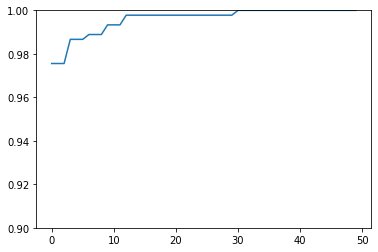

In [139]:
plt.plot(list(range(50)),cmc_curve)
plt.ylim(0.9,1)

In [141]:
cmc_curve[:20]

[0.9755555555555555,
 0.9755555555555555,
 0.9755555555555555,
 0.9866666666666667,
 0.9866666666666667,
 0.9866666666666667,
 0.9888888888888889,
 0.9888888888888889,
 0.9888888888888889,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778,
 0.9977777777777778]